In [3]:
import datetime
import time

from pycds import *
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import and_, or_
from sqlalchemy.sql import func
from sqlalchemy import funcfilter
from sqlalchemy import within_group
from sqlalchemy import select

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgpasslib

In [4]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind = engine)
session = Session()
session.flush()

In [5]:
year = 2000 
month = 1
day = 1
interval = 1
yr_interval = 1

start_year = datetime.datetime(year, month, day)
end_year = datetime.datetime(year + yr_interval, month, day)

start_time = datetime.datetime(year, month, day)
end_time = datetime.datetime(year + 3, month, day)

In [6]:
query = session.query(Variable.description, Variable.id, Variable.standard_name, Variable.id, Variable.unit)
df_vars = pd.read_sql(query.statement, engine)

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_vars)

                                      long_description  vars_id  \
0                                                 Hail     1401   
1                                        Smoke or Haze     1424   
2                           Ceiling currently observed     1291   
3                        Visibility currently observed     1292   
4                                  Sea level pressure      1293   
5                               Dew point temperature      1294   
6                                16 pts up to Dec 1970     1295   
7                                           Wind speed     1297   
8                                    Station pressure      1298   
9                             AKA Dry Bulb Temperature     1299   
10                                Wet bulb temperature     1300   
11                                  Relative humidity      1301   
12                                 Total cloud opacity     1302   
13                                  Total cloud amount     130

In [8]:
#df_all_temp['datum'].hist()

In [9]:
session = Session()
session.flush()

def baseline(start_time, end_time):
    query = session.query(Obs.datum, Obs.time, Variable.standard_name, History.station_id).filter(Obs.time <= end_time).filter(Obs.time >= start_time).join(History).join(Variable)
    return query

def precip_query(start_time, end_time):
    query = baseline(start_time, end_time).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    return query

def temp_query(start_time, end_time):
    query = baseline(start_time, end_time).filter(Variable.standard_name == "air_temperature").filter(or_(Variable.description == "Air temperature", Variable.id == 1510))
    return query

def annual_rain(start_year, end_year, mean = True):
    yr_interval = float(np.abs(end_year.year - start_year.year))
    print(yr_interval)
    query = session.query(func.sum(Obs.datum*0.1/yr_interval).label("sum"), func.max(Obs.time).label("max_date"), History.lat, History.lon, History.station_id).group_by(History).having(func.max(Obs.time) >= end_year).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    query = query.filter(Obs.time <= end_year).filter(Obs.time >= start_year).join(History).join(Variable)
    return query

def design_temp_25(month=1):

    query = session.query(func.percentile_cont(0.025).within_group(
                    Obs.datum.asc()).label("temp"),
                    func.min(Obs.time).label("time_min"),
                    func.max(Obs.time).label("time_max"),
                    History.lat,
                    History.lon,
                    History.station_id,
                    History.station_name.label("station_name")).group_by(History) \
                    .filter(and_(Variable.standard_name == 'air_temperature',
                                 Variable.id == 1510)) \
                    .filter(func.extract("month", Obs.time) == 1).join(History)
    
    return query

def design_temp_1(month=1):

    query = session.query(func.percentile_cont(0.01).within_group(
                            Obs.datum.asc()).label("temp"),
                            func.min(Obs.time).label("time_min"),
                            func.max(Obs.time).label("time_max"),
                            History.lat,
                            History.lon,
                            History.station_id,
                            History.station_name).group_by(History) \
                            .filter(and_(Variable.standard_name == 'air_temperature',
                                         Variable.id == 1510)) \
                            .filter(func.extract("month", Obs.time) == 1).join(History)

    return query

def design_temp_25_wet(month=7):

    query = session.query(func.percentile_cont(0.025).within_group(
                          Obs.datum.desc()).label("wet_temp"),
                          func.min(Obs.time).label("time_min"),
                          func.max(Obs.time).label("time_max"),
                          History.lat,
                          History.lon,
                          History.station_id).group_by(History) \
                          .filter(and_(Variable.standard_name == 'air_temperature',
                                       Variable.id == 1300)) \
                          .filter(func.extract("month", Obs.time) == month).join(History)

    return query

def design_temp_25_dry(month=7):

    query = session.query(func.percentile_cont(0.025).within_group(
                            Obs.datum.desc()).label("dry_temp"),
                            func.min(Obs.time).label("time_min"),
                            func.max(Obs.time).label("time_max"),
                            History.lat,
                            History.lon,
                            History.station_id).group_by(History) \
                            .filter(and_(Variable.standard_name == 'air_temperature',
                                         Variable.id == 1299)) \
                            .filter(func.extract("month", Obs.time) == month).join(History)

    return query

def daily_mean_query():
    yr_interval = float(np.abs(end_time.year - start_time.year))
    query = session.query(func.sum(18.0-Obs.datum*0.1)/yr_interval, Variable.description,
                          History.lat, History.lon) \
                                    .group_by(History.lat, History.lon, History.station_id, Variable) \
                                    .filter(and_(Obs.time<=end_time, Obs.time>=start_time)) \
                                    .filter((180.0 - Obs.datum)>0.0) \
                                    .filter(and_(Variable.standard_name == 'air_temperature',
                                            Variable.id==1394)) \
                                    .filter(History.province == 'BC') \
                                    .join(History).join(Variable) \
                                    .limit(100000)
    return query

def deg_day_below_18_query():
    
    yr_interval = float(np.abs(end_time.year - start_time.year))
    print(yr_interval, 'year interval')
    query = session.query(func.sum((18.0-Obs.datum*0.1)/yr_interval).label("dd_sum"), 
                      func.min(Obs.time).label("min_date"),
                      func.max(Obs.time).label("max_date"), 
                      func.sum(func.extract("day", Obs.time)),    
                      History.lat, History.lon, 
                      History.station_id).join(History).join(Variable)
    
    query = query.group_by(History.lat, History.lon, History.station_id) \
                 .filter((180.0 - Obs.datum)>0.0) \
                 .filter(and_(Obs.time<=end_time, Obs.time>=start_time)) \
                 .having((func.extract("year", func.max(Obs.time))-func.extract("year", func.min(Obs.time))) >= yr_interval) \
                 .filter(and_(Variable.standard_name == 'air_temperature',
                              Variable.id==1394))
    return query

def show_design_values():
    query = session.query(Variable.standard_name, Variable.description, Variable.unit, Variable.id)
    return query

In [10]:
q = deg_day_below_18_query()
df_q = pd.read_sql(q.statement, engine)

3.0 year interval


In [116]:
df_q

,anon_1,long_description,lat,lon
0,2560.066667,Daily mean temperature,48.3397,-123.539
1,2868.000000,Daily mean temperature,48.3767,-123.921
2,2956.866667,Daily mean temperature,48.4058,-123.991
3,2738.266667,Daily mean temperature,48.4131,-123.325
4,2731.100000,Daily mean temperature,48.4133,-123.325
5,2365.633333,Daily mean temperature,48.4246,-123.226
6,2832.366667,Daily mean temperature,48.4320,-123.439
7,1478.400000,Daily mean temperature,48.4550,-123.267
8,2683.666667,Daily mean temperature,48.4570,-123.305
9,3212.933333,Daily mean temperature,48.5092,-123.508


In [117]:
q_1 = deg_day_below_18_query()

start = time.time()
df_1 = pd.read_sql(q_1.statement, engine)
end = time.time()

print('{} seconds, {} minutes'.format(end - start, (end - start)/60.))

3.0 year interval
9.684898376464844 seconds, 0.16141497294108073 minutes


In [118]:
#q_1 = design_temp_1()
#q_25 = design_temp_25(start_year, end_year)
#df_temp = df_1[df_1['dd_sum'] <=50000]
#df_temp['dd_sum'].hist()
#df_1
df_q

,anon_1,long_description,lat,lon
0,2560.066667,Daily mean temperature,48.3397,-123.539
1,2868.000000,Daily mean temperature,48.3767,-123.921
2,2956.866667,Daily mean temperature,48.4058,-123.991
3,2738.266667,Daily mean temperature,48.4131,-123.325
4,2731.100000,Daily mean temperature,48.4133,-123.325
5,2365.633333,Daily mean temperature,48.4246,-123.226
6,2832.366667,Daily mean temperature,48.4320,-123.439
7,1478.400000,Daily mean temperature,48.4550,-123.267
8,2683.666667,Daily mean temperature,48.4570,-123.305
9,3212.933333,Daily mean temperature,48.5092,-123.508


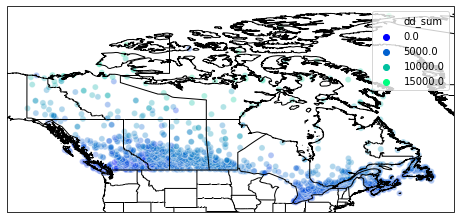

In [137]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(df_1['lon'], df_1['lat'], hue=df_1['dd_sum'], palette="winter", alpha=.3)
plt.savefig('canada_degree_days_18.pdf')
#plt.ylim(40, 80)
#plt.xlim(-126, -119)

In [88]:
#df_1.sort_values(by='lat', ascending=False)

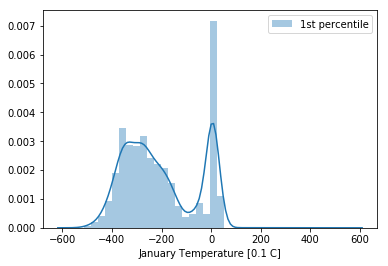

In [93]:
sns.distplot(df_1['temp'], label = "1st percentile")#.hist()
#sns.distplot(df_25['temp'], label = "2.5th percentile")
plt.xlabel("January Temperature [0.1 C]" )
plt.legend()
plt.savefig("jan_air_temp_percentiles")
plt.show()

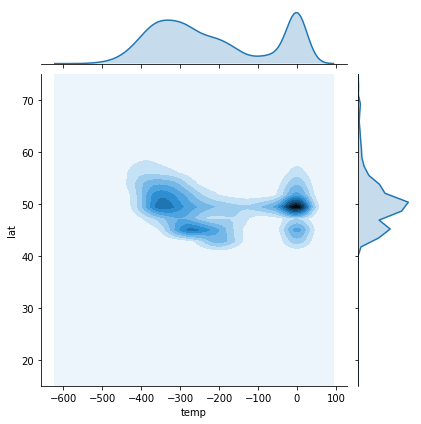

In [36]:
#ax = sns.jointplot(x="temp", y="lat", kind = 'kde', data=df, label = '1st percentile')
#plt.ylim(15., 75.)
#plt.savefig("kde_density_1st_temp")

ax = sns.jointplot(x="temp", y="lat", kind = 'kde', data=df_1, label = '2.5th percentile')
plt.ylim(15., 75.)
plt.savefig("kde_density_25th_temp")

#sns.jointplot(x="anon_1", y="lat", kind=   'kde', data=df1)
#plt.title('Joint Plot of Temp Distribution with Latitude 2nd percentile')
#plt.xlabel('Temperature [0.1 C]')
#plt.ylim(25., 75.)

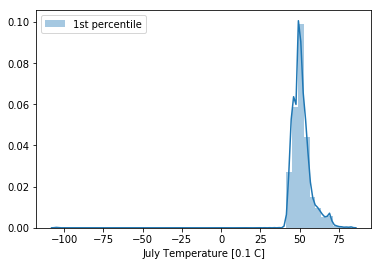

In [9]:
sns.distplot(df['lat'], label = "1st percentile")#.hist()
#sns.distplot(df1['lat'], label = "2.5th percentile")
plt.xlabel("July Temperature [0.1 C]" )
plt.legend()
plt.savefig("july_air_temp_percentiles")
plt.show()

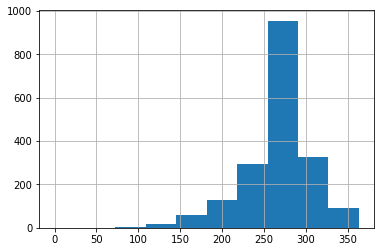

In [13]:
df['anon_1'].hist() 

In [ ]:
sns.distplot(df['datum'])
plt.xlabel('July Temperature [0.1 C]')
plt.ylabel('KDE Frequency')
plt.savefig('temp_percentile_25')

In [9]:
plt.scatter(df['lon'], df['lat'])
plt.ylim(45, 60)

KeyError: 'lon'